In [9]:
!pip install geopandas==0.12.1;
!pip install rtree;
!pip install pyarrow==10.0.0 s3fs folium

In [147]:
import os
os.getcwd()

'/home/onyxia/work/hackathon-un-2022'

In [148]:
os.chdir("..")
import utils.functions as fc

In [149]:
from importlib import reload
fc = reload(fc)

In [150]:
ship_data_enriched = fc.create_ship_data_enriched()

In [151]:
path_parquet = "AIS/ais_azov_black_20220401_20220408_full_traces.parquet"

ais_df = fc.read_ais_parquet(path_parquet=path_parquet)

In [152]:
ais_df.shape

(4406590, 6)

In [153]:
import pandas as pd

pd.options.display.max_columns = 30
ais_df.head()

,mmsi,latitude,longitude,eeid,dt_insert_utc,destination
0,249637000,44.305513,30.317422,NaN,2019-03-25 08:34:45,BILBAO
1,511942000,44.208553,30.109788,NaN,2019-03-25 04:05:53,KHERSON
2,511942000,44.327867,30.157003,NaN,2019-03-25 05:02:12,KHERSON
3,511942000,44.324473,30.155405,NaN,2019-03-25 05:00:33,KHERSON
4,235105944,40.978187,29.039550,NaN,2019-03-25 03:41:31,None


In [156]:
ais_df.columns

Index(['mmsi', 'latitude', 'longitude', 'eeid', 'dt_insert_utc',
       'destination'],
      dtype='object')

In [157]:
import pandas as pd
import rtree
import geopandas as gpd
from shapely.geometry import Point, mapping, Polygon
import re
import folium
import numpy as np
from datetime import datetime
import pyspark.sql.functions as F
from pyarrow import fs
import pyarrow as pa
import pyarrow.parquet as pq

## Processing port data

In [158]:
df = pd.read_csv('https://msi.nga.mil/api/publications/download?type=view&key=16920959/SFH00000/UpdatedPub150.csv')

df = df[['World Port Index Number', 'Region Name', 'Main Port Name', 'World Water Body', 'Country Code', 'Latitude', 'Longitude']].rename(
    columns={
        'World Port Index Number': 'id',
        'Region Name': 'region_name',
        'Main Port Name': 'port_name',
        'World Water Body': 'water_body',
        'Country Code': 'country',
        'Latitude': 'lat',
        'Longitude':'long'
    }
)

In [159]:
df['coordinates'] = [Point(xy) for xy in zip(df.long, df.lat)] 

/opt/mamba/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [160]:
# Note cap_style: round = 1, flat = 2, square = 3
df['port_coverage'] = gpd.GeoSeries(df['coordinates']).buffer(0.04, cap_style = 3)

Creating buffer.

In [161]:
df['port_buffer'] = gpd.GeoSeries(df['coordinates']).buffer(0.08, cap_style = 3)

In [162]:
df1 = gpd.GeoDataFrame({'geometry': df['port_coverage'], 'df1': df['id']})
df2 = gpd.GeoDataFrame({'geometry': df['port_buffer'], 'df2': df['id']})
res_difference = df2.overlay(df1, how='difference')
df['port_buffer'] = res_difference['geometry']

Filtering ports from the Azov and Black seas: now we're not doing this anymore

In [166]:
# df_black_azov = df[df['water_body'].str.contains('Black', case=False)]
df_black_azov = df

In [167]:
df_black_azov.shape

(2880, 10)

There are 49 ports listed for the Azov and the Black seas. This list might not complete though ? See for example Marioupol in the Azov sea which does have a port ?

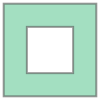

In [168]:
df_black_azov.port_buffer.iloc[0]

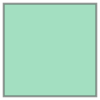

In [169]:
df_black_azov.port_coverage.iloc[0]

Plotting port coverages and buffers

In [182]:
m = folium.Map(location=[43.433333, 39.933333])

for i in range(0, len(df_black_azov)):
    # Plot port coordinates
    folium.Marker([df_black_azov.iloc[i]['lat'], df_black_azov.iloc[i]['long']],
                  popup=df_black_azov.iloc[i]['port_name']).add_to(m)

    # Plot port coverage
    coverage = gpd.GeoSeries(df_black_azov.iloc[i]['port_coverage']).simplify(tolerance=0.001)
    geo_j = coverage.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)
    
    # Plot port buffer
    buffer = gpd.GeoSeries(df_black_azov.iloc[i]['port_buffer']).simplify(tolerance=0.001)
    buffer_geo_j = buffer.to_json()
    buffer_geo_j = folium.GeoJson(data=buffer_geo_j,
                                  style_function=lambda x: {'fillColor': 'purple'})
    buffer_geo_j.add_to(m)

In [175]:
m

Cleaning ports

In [176]:
df_black_azov

,id,region_name,port_name,water_body,country,lat,long,coordinates,port_coverage,port_buffer
0,4580,US Lake Michigan -- 4570,St. James Harbor,Lake Michigan; Great Lakes,United States,45.733333,-85.516667,POINT (-85.516667 45.733333),"POLYGON ((-85.47667 45.77333, -85.47667 45.693...","POLYGON ((-85.43667 45.65333, -85.59667 45.653..."
1,63110,Antarctica -- 63060,Melchior Harbor,South Pacific Ocean,Antarctica,-64.316667,-63.000000,POINT (-63 -64.316667),"POLYGON ((-62.96000 -64.27667, -62.96000 -64.3...","POLYGON ((-63.08000 -64.39667, -63.08000 -64.2..."
2,52350,Sulawesi -- 51970,Donggala,Makassar Strait; South Pacific Ocean,Indonesia,-0.650000,119.733333,POINT (119.733333 -0.65),"POLYGON ((119.77333 -0.61000, 119.77333 -0.690...","POLYGON ((119.81333 -0.73000, 119.65333 -0.730..."
3,46544,Angola -- 46540,Psvm Terminal,South Atlantic Ocean,Angola,-6.250000,10.733333,POINT (10.733333 -6.25),"POLYGON ((10.77333 -6.21000, 10.77333 -6.29000...","POLYGON ((10.81333 -6.33000, 10.65333 -6.33000..."
4,56820,Bismarck Archipelago -- 56700,Kokopo,Bismarck Sea; South Pacific Ocean,Papua New Guinea,-4.333333,152.266667,POINT (152.266667 -4.333333),"POLYGON ((152.30667 -4.29333, 152.30667 -4.373...","POLYGON ((152.34667 -4.41333, 152.18667 -4.413..."
...,...,...,...,...,...,...,...,...,...,...
2875,62070,Japan -- 61100,Imabari Ko,Sea of Japan; North Pacific Ocean,Japan,34.066667,133.016667,POINT (133.016667 34.066667),"POLYGON ((133.05667 34.10667, 133.05667 34.026...","POLYGON ((133.09667 33.98667, 132.93667 33.986..."
2876,8490,United States E Coast -- 6585,Georgetown,North Atlantic Ocean,United States,33.366667,-79.283333,POINT (-79.283333 33.366667),"POLYGON ((-79.24333 33.40667, -79.24333 33.326...","POLYGON ((-79.20333 33.28667, -79.36333 33.286..."
2877,14100,Chile -- 14070,Rada Punta Arenas,South Pacific Ocean,Chile,-53.166667,-70.900000,POINT (-70.9 -53.166667),"POLYGON ((-70.86000 -53.12667, -70.86000 -53.2...","POLYGON ((-70.82000 -53.24667, -70.98000 -53.2..."
2878,38220,Spain SW Coast -- 38200,Huelva,North Atlantic Ocean,Spain,37.250000,-6.950000,POINT (-6.95 37.25),"POLYGON ((-6.91000 37.29000, -6.91000 37.21000...","POLYGON ((-6.87000 37.17000, -7.03000 37.17000..."


## Preparing data for the `get_ais` function

In [177]:
df_black_azov.shape

(2880, 10)

In [178]:
df_black_azov[~df_black_azov.id.duplicated()].shape

(2880, 10)

In [179]:
df_black_azov[['id', 'port_coverage']].shape

(2880, 2)

In [180]:
from geopandas import gpd 

ports = gpd.GeoDataFrame(df_black_azov[['id', 'port_coverage']]).rename(
    columns={'port_coverage': 'polygon'}
)
ports['buffer'] = 0
port_buffers = gpd.GeoDataFrame(df_black_azov[['id', 'port_buffer']]).rename(
    columns={'port_buffer': 'polygon'}
)
port_buffers['buffer'] = 1
polys = gpd.GeoDataFrame(pd.concat([ports, port_buffers], ignore_index=True),
                         geometry='polygon')

In [181]:
polys[polys.id.duplicated()]

,id,polygon,buffer
2880,4580,"POLYGON ((-85.43667 45.65333, -85.59667 45.653...",1
2881,63110,"POLYGON ((-63.08000 -64.39667, -63.08000 -64.2...",1
2882,52350,"POLYGON ((119.81333 -0.73000, 119.65333 -0.730...",1
2883,46544,"POLYGON ((10.81333 -6.33000, 10.65333 -6.33000...",1
2884,56820,"POLYGON ((152.34667 -4.41333, 152.18667 -4.413...",1
...,...,...,...
5755,62070,"POLYGON ((133.09667 33.98667, 132.93667 33.986...",1
5756,8490,"POLYGON ((-79.20333 33.28667, -79.36333 33.286...",1
5757,14100,"POLYGON ((-70.82000 -53.24667, -70.98000 -53.2...",1
5758,38220,"POLYGON ((-6.87000 37.17000, -7.03000 37.17000...",1


In [41]:
def filter_ports(df):
    """
    In original df there must be a latitude and longitude
    
    Returns df.
    """
    df['coordinates'] = [Point(xy) for xy in zip(df.longitude, df.latitude)] 
    points = gpd.GeoDataFrame(df, geometry='coordinates')
    points_in_polys = gpd.sjoin(points, polys, op='within')
    return points_in_polys

In [64]:
filtered_df = filter_ports(ais_df)

/opt/mamba/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/opt/mamba/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3378: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [65]:
filtered_df.shape

(985717, 30)

In [66]:
filtered_df['polygon'] = [str(a) + '_' + str(b) for a, b in zip(filtered_df['id'], filtered_df['buffer'])]

In [68]:
filtered_df.head()

,width,dt_static_utc,vessel_type_cargo,length,nav_status,dt_pos_utc,heading,cog,rot,dt_insert_utc,vessel_type_main,sog,draught,latitude,polygon_name,...,vessel_name,vessel_type_sub,H3_int_index_9,hex_resolution,longitude,mmsi,flag_country,destination,vessel_class,imo,coordinates,index_right,id,buffer,polygon
0,47.0,2019-04-01 09:34:20,None,71.0,Not Defined,2019-04-01 10:00:59,0.0,0.0,0.0,2019-04-01 10:00:59,Offshore Vessel,0.0,0.0,45.561487,Chornomors Ke Buffer,...,MODU SIVASH,None,617787929049432063,9,32.774457,273374830,Russian Federation,None,A,8763385.0,POINT (32.77446 45.56149),97,43745,1,43745_1
7872,21.0,2019-04-01 22:57:23,None,51.0,Under Way Using Engine,2019-04-01 23:30:30,0.0,64.2,0.0,2019-04-01 23:30:30,Service Ship,1.2,2.5,45.566382,Chornomors Ke Buffer,...,NEPTUN-3,Crane Ship,617527075095183359,9,32.663027,273371570,Russian Federation,BLACK SEA,A,8860511.0,POINT (32.66303 45.56638),97,43745,1,43745_1
7873,21.0,2019-04-01 22:57:23,None,51.0,Under Way Using Engine,2019-04-01 22:59:04,0.0,99.8,0.0,2019-04-01 22:59:04,Service Ship,1.9,2.5,45.564717,Chornomors Ke Buffer,...,NEPTUN-3,Crane Ship,617527075096231935,9,32.644928,273371570,Russian Federation,BLACK SEA,A,8860511.0,POINT (32.64493 45.56472),97,43745,1,43745_1
7875,21.0,2019-04-01 21:51:21,None,51.0,Under Way Using Engine,2019-04-01 22:08:30,0.0,91.4,0.0,2019-04-01 22:08:30,Service Ship,1.4,2.5,45.561020,Chornomors Ke Buffer,...,NEPTUN-3,Crane Ship,617527077484625919,9,32.620610,273371570,Russian Federation,BLACK SEA,A,8860511.0,POINT (32.62061 45.56102),97,43745,1,43745_1
18469,21.0,2019-04-01 22:57:23,None,51.0,Under Way Using Engine,2019-04-01 23:09:30,0.0,94.7,0.0,2019-04-01 23:09:30,Service Ship,1.8,2.5,45.564647,Chornomors Ke,...,NEPTUN-3,Crane Ship,617527075095969791,9,32.651615,273371570,Russian Federation,BLACK SEA,A,8860511.0,POINT (32.65161 45.56465),97,43745,1,43745_1


## Assign route

In [69]:
filtered_df = filtered_df.sort_values(by=['mmsi', 'dt_pos_utc', 'dt_static_utc'])
filtered_df

,width,dt_static_utc,vessel_type_cargo,length,nav_status,dt_pos_utc,heading,cog,rot,dt_insert_utc,vessel_type_main,sog,draught,latitude,polygon_name,...,vessel_name,vessel_type_sub,H3_int_index_9,hex_resolution,longitude,mmsi,flag_country,destination,vessel_class,imo,coordinates,index_right,id,buffer,polygon
93225,0.0,2019-03-31 23:59:55,None,0.0,Engaged In Fishing,2019-04-01 00:00:19,0.0,47.3,0.0,2019-04-01 00:00:19,None,0.1,25.5,41.725078,Batumi Buffer,...,UNAVAILABLE,None,617769527947034623,9,41.728247,2060,None,None,A,NaN,POINT (41.72825 41.72508),81,44350,1,44350_1
27576,0.0,2019-03-31 23:59:55,None,0.0,Engaged In Fishing,2019-04-01 00:10:28,0.0,170.5,0.0,2019-04-01 00:10:28,None,0.1,25.5,41.725092,Batumi Buffer,...,UNAVAILABLE,None,617769527947034623,9,41.728248,2060,None,None,A,NaN,POINT (41.72825 41.72509),81,44350,1,44350_1
60136,0.0,2019-04-01 00:11:57,None,0.0,Engaged In Fishing,2019-04-01 00:20:29,0.0,173.5,0.0,2019-04-01 00:20:29,None,0.1,25.5,41.725072,Batumi Buffer,...,UNAVAILABLE,None,617769527947034623,9,41.728250,2060,None,None,A,NaN,POINT (41.72825 41.72507),81,44350,1,44350_1
72340,0.0,2019-04-01 00:23:58,None,0.0,Engaged In Fishing,2019-04-01 00:30:39,0.0,171.8,0.0,2019-04-01 00:30:39,None,0.1,25.5,41.725063,Batumi Buffer,...,UNAVAILABLE,None,617769527947034623,9,41.728225,2060,None,None,A,NaN,POINT (41.72823 41.72506),81,44350,1,44350_1
72338,0.0,2019-04-01 00:23:58,None,0.0,Engaged In Fishing,2019-04-01 00:40:39,0.0,171.8,0.0,2019-04-01 00:40:39,None,0.1,25.5,41.725037,Batumi Buffer,...,UNAVAILABLE,None,617769527947034623,9,41.728225,2060,None,None,A,NaN,POINT (41.72823 41.72504),81,44350,1,44350_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540577,NaN,NaT,None,NaN,Not Defined,2019-04-05 13:17:54,0.0,0.0,0.0,2019-04-05 13:17:54,None,0.0,0.0,46.307500,Illichivsk Buffer,...,UNAVAILABLE,None,617527327395151871,9,30.723400,992726016,None,None,A,NaN,POINT (30.72340 46.30750),77,43645,1,43645_1
778731,NaN,NaT,None,NaN,Not Defined,2019-04-07 13:23:48,0.0,0.0,0.0,2019-04-07 13:23:48,None,0.0,0.0,46.307500,Illichivsk Buffer,...,UNAVAILABLE,None,617527327395151871,9,30.723400,992726016,None,None,A,NaN,POINT (30.72340 46.30750),77,43645,1,43645_1
139696,NaN,NaT,None,NaN,Not Defined,2019-04-02 21:17:23,0.0,0.0,0.0,2019-04-02 21:17:23,None,0.0,0.0,46.307900,Illichivsk Buffer,...,UNAVAILABLE,None,617527327395151871,9,30.724100,992726017,None,None,A,NaN,POINT (30.72410 46.30790),77,43645,1,43645_1
291377,NaN,NaT,None,NaN,Not Defined,2019-04-03 11:11:23,0.0,0.0,0.0,2019-04-03 11:11:23,None,0.0,0.0,46.307900,Illichivsk Buffer,...,UNAVAILABLE,None,617527327395151871,9,30.724100,992726017,None,None,A,NaN,POINT (30.72410 46.30790),77,43645,1,43645_1


In [70]:
filtered_df['d_dt_pos'] = filtered_df['dt_pos_utc'] - filtered_df['dt_pos_utc'].shift(-1)
filtered_df['d_dt_static'] = filtered_df['dt_static_utc'] - filtered_df['dt_static_utc'].shift(-1)

In [71]:
polygon_mapping = {
    polygon: index for polygon, index in zip(filtered_df.polygon.unique(), np.arange(filtered_df.polygon.nunique()))
}

In [72]:
filtered_df['polygon'] = filtered_df['polygon'].map(polygon_mapping)
filtered_df.head()

,width,dt_static_utc,vessel_type_cargo,length,nav_status,dt_pos_utc,heading,cog,rot,dt_insert_utc,vessel_type_main,sog,draught,latitude,polygon_name,...,H3_int_index_9,hex_resolution,longitude,mmsi,flag_country,destination,vessel_class,imo,coordinates,index_right,id,buffer,polygon,d_dt_pos,d_dt_static
93225,0.0,2019-03-31 23:59:55,None,0.0,Engaged In Fishing,2019-04-01 00:00:19,0.0,47.3,0.0,2019-04-01 00:00:19,None,0.1,25.5,41.725078,Batumi Buffer,...,617769527947034623,9,41.728247,2060,None,None,A,NaN,POINT (41.72825 41.72508),81,44350,1,0,-1 days +23:49:51,0 days 00:00:00
27576,0.0,2019-03-31 23:59:55,None,0.0,Engaged In Fishing,2019-04-01 00:10:28,0.0,170.5,0.0,2019-04-01 00:10:28,None,0.1,25.5,41.725092,Batumi Buffer,...,617769527947034623,9,41.728248,2060,None,None,A,NaN,POINT (41.72825 41.72509),81,44350,1,0,-1 days +23:49:59,-1 days +23:47:58
60136,0.0,2019-04-01 00:11:57,None,0.0,Engaged In Fishing,2019-04-01 00:20:29,0.0,173.5,0.0,2019-04-01 00:20:29,None,0.1,25.5,41.725072,Batumi Buffer,...,617769527947034623,9,41.728250,2060,None,None,A,NaN,POINT (41.72825 41.72507),81,44350,1,0,-1 days +23:49:50,-1 days +23:47:59
72340,0.0,2019-04-01 00:23:58,None,0.0,Engaged In Fishing,2019-04-01 00:30:39,0.0,171.8,0.0,2019-04-01 00:30:39,None,0.1,25.5,41.725063,Batumi Buffer,...,617769527947034623,9,41.728225,2060,None,None,A,NaN,POINT (41.72823 41.72506),81,44350,1,0,-1 days +23:50:00,0 days 00:00:00
72338,0.0,2019-04-01 00:23:58,None,0.0,Engaged In Fishing,2019-04-01 00:40:39,0.0,171.8,0.0,2019-04-01 00:40:39,None,0.1,25.5,41.725037,Batumi Buffer,...,617769527947034623,9,41.728225,2060,None,None,A,NaN,POINT (41.72823 41.72504),81,44350,1,0,-1 days +23:49:50,-1 days +23:41:57


In [83]:
from datetime import timedelta
THRESHOLD = timedelta(
    days=0,
    seconds=0,
    microseconds=0,
    milliseconds=0,
    minutes=0,
    hours=12,
    weeks=0
)
THRESHOLD

datetime.timedelta(seconds=43200)

In [109]:
def assign_routes_to_group(x):
    polygon_diff = x['polygon'].diff().ne(0)
    time_diff = x['d_dt_pos'] < -1 * THRESHOLD
    buffer = x['buffer']
    return (polygon_diff | (time_diff & buffer)).cumsum()

In [110]:
filtered_df['route'] =  filtered_df.groupby('mmsi').apply(
    assign_routes_to_group
).reset_index(level=0, drop=True)

Checking when two consecutive obs. with equal pos datetime

In [120]:
pd.options.display.max_columns = None

In [121]:
filtered_df[filtered_df['d_dt_pos'] == timedelta(
    days=0,
    seconds=0,
    microseconds=0,
    milliseconds=0,
    minutes=0,
    hours=0,
    weeks=0
)].sort_values(by=['mmsi', 'dt_pos_utc', 'dt_static_utc'])

,width,dt_static_utc,vessel_type_cargo,length,nav_status,dt_pos_utc,heading,cog,rot,dt_insert_utc,vessel_type_main,sog,draught,latitude,polygon_name,vessel_type,vessel_name,vessel_type_sub,H3_int_index_9,hex_resolution,longitude,mmsi,flag_country,destination,vessel_class,imo,coordinates,index_right,id,buffer,polygon,d_dt_pos,d_dt_static,route
98813,2.0,2019-04-01 00:03:53,None,12.0,Not Defined,2019-04-01 00:07:06,0.0,253.2,0.0,2019-04-01 00:07:06,None,0.0,0.0,42.153715,Supsa Marine Terminal Buffer,Unknown,POTI,None,617769509610586111,9,41.655695,2130300,None,None,A,NaN,POINT (41.65570 42.15371),66,44345,1,2,0 days,0 days,1
264,2.0,2019-04-01 00:03:53,None,12.0,Not Defined,2019-04-01 00:09:46,0.0,253.2,0.0,2019-04-01 00:09:46,None,0.0,0.0,42.153745,Supsa Marine Terminal Buffer,Unknown,POTI,None,617769509610586111,9,41.655675,2130300,None,None,A,NaN,POINT (41.65568 42.15375),66,44345,1,2,0 days,0 days,3
71965,2.0,2019-04-01 00:15:52,None,12.0,Not Defined,2019-04-01 00:20:15,0.0,253.2,0.0,2019-04-01 00:20:15,None,0.0,0.0,42.153745,Supsa Marine Terminal Buffer,Unknown,POTI,None,617769509610586111,9,41.655700,2130300,None,None,A,NaN,POINT (41.65570 42.15375),66,44345,1,2,0 days,0 days,5
98829,2.0,2019-04-01 00:27:55,None,12.0,Not Defined,2019-04-01 00:32:17,0.0,253.2,0.0,2019-04-01 00:32:17,None,0.0,0.0,42.153735,Supsa Marine Terminal Buffer,Unknown,POTI,None,617769509610586111,9,41.655680,2130300,None,None,A,NaN,POINT (41.65568 42.15373),66,44345,1,2,0 days,0 days,7
98806,2.0,2019-04-01 00:39:56,None,12.0,Not Defined,2019-04-01 00:43:15,0.0,253.2,0.0,2019-04-01 00:43:15,None,0.0,0.0,42.153740,Supsa Marine Terminal Buffer,Unknown,POTI,None,617769509610586111,9,41.655780,2130300,None,None,A,NaN,POINT (41.65578 42.15374),66,44345,1,2,0 days,0 days,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986460,14.0,2019-04-08 23:13:46,None,82.0,At Anchor,2019-04-08 23:21:14,32.0,0.0,0.0,2019-04-08 23:21:14,Service Ship,0.0,0.0,46.875707,Mykolayiv Buffer,Dredging,GINGER,Hopper Dredger,617526307708469247,9,31.993037,677072700,Tanzania,-,A,6521915.0,POINT (31.99304 46.87571),64,43670,1,46,0 days,0 days,1989
931834,14.0,2019-04-08 23:25:46,None,82.0,At Anchor,2019-04-08 23:33:14,144.0,0.0,0.0,2019-04-08 23:33:14,Service Ship,0.0,0.0,46.875675,Mykolayiv Buffer,Dredging,GINGER,Hopper Dredger,617526307708469247,9,31.993143,677072700,Tanzania,-,A,6521915.0,POINT (31.99314 46.87568),64,43670,1,46,0 days,0 days,1991
894840,14.0,2019-04-08 23:37:46,None,82.0,At Anchor,2019-04-08 23:45:14,26.0,0.0,0.0,2019-04-08 23:45:14,Service Ship,0.0,0.0,46.875658,Mykolayiv Buffer,Dredging,GINGER,Hopper Dredger,617526307708469247,9,31.993123,677072700,Tanzania,-,A,6521915.0,POINT (31.99312 46.87566),64,43670,1,46,0 days,0 days,1993
1010318,14.0,2019-04-08 23:37:46,None,82.0,At Anchor,2019-04-08 23:47:09,0.0,0.0,0.0,2019-04-08 23:47:09,Service Ship,0.0,0.0,46.875000,Mykolayiv Buffer,Dredging,GINGER,Hopper Dredger,617526295213375487,9,31.991667,677072700,Tanzania,-,A,6521915.0,POINT (31.99167 46.87500),64,43670,1,46,0 days,0 days,1995


Happens quite rarely : polygons intersecting ?

## RESET : enchaînement des destinations ? 

In [183]:
ais_df.shape

(4406590, 6)

In [192]:
ais_df = ais_df.sort_values(by=['mmsi', 'dt_insert_utc'])

In [199]:
destination_mapping = {
    destination: index for destination, index in zip(ais_df.destination.unique(), np.arange(ais_df.destination.nunique()))
}

In [201]:
ais_df['destination_index'] = ais_df['destination'].map(destination_mapping)
ais_df['destination_index'] = ais_df['destination_index'].fillna(-1)
ais_df['destination_index'] = ais_df['destination_index'].astype(int)
ais_df.head()

,mmsi,latitude,longitude,eeid,dt_insert_utc,destination,destination_index
89968,203999383,45.826287,18.852413,NaN,2019-03-25 02:25:41,CONSTANTA,0
89965,203999383,45.810085,18.848063,NaN,2019-03-25 02:36:02,CONSTANTA,0
113865,203999383,45.793502,18.853033,NaN,2019-03-25 02:46:41,CONSTANTA,0
150165,203999383,45.793228,18.853223,NaN,2019-03-25 02:46:52,CONSTANTA,0
113864,203999383,45.784790,18.872357,NaN,2019-03-25 02:57:05,CONSTANTA,0


In [204]:
def assign_routes_to_group(x):
    return x['destination_index'].diff().ne(0).cumsum()

In [205]:
ais_df['route'] =  ais_df.groupby('mmsi').apply(
    assign_routes_to_group
).reset_index(level=0, drop=True)

In [206]:
ais_df.head()

,mmsi,latitude,longitude,eeid,dt_insert_utc,destination,destination_index,route
89968,203999383,45.826287,18.852413,NaN,2019-03-25 02:25:41,CONSTANTA,0,1
89965,203999383,45.810085,18.848063,NaN,2019-03-25 02:36:02,CONSTANTA,0,1
113865,203999383,45.793502,18.853033,NaN,2019-03-25 02:46:41,CONSTANTA,0,1
150165,203999383,45.793228,18.853223,NaN,2019-03-25 02:46:52,CONSTANTA,0,1
113864,203999383,45.784790,18.872357,NaN,2019-03-25 02:57:05,CONSTANTA,0,1


In [314]:
routes_df = ais_df.groupby(['mmsi', 'route', 'destination']).agg(
    {
        'dt_insert_utc': ['first', 'last'], 
        'latitude': ['first', 'last'], 
        'longitude': ['first', 'last'],
        'route': 'count'
    }
)

In [315]:
routes_df.columns = routes_df.columns.map('_'.join).str.strip('_')

In [316]:
routes_df.reset_index()

,mmsi,route,destination,dt_insert_utc_first,dt_insert_utc_last,latitude_first,latitude_last,longitude_first,longitude_last,route_count
0,203999383,1,CONSTANTA,2019-03-25 02:25:41,2019-03-25 05:26:00,45.826287,45.588313,18.852413,18.902228,35
1,203999383,2,KLIZSKA NEMA,2019-03-25 05:33:54,2019-03-25 05:33:54,45.577460,45.577460,18.889852,18.889852,1
2,203999383,3,CONSTANTA,2019-03-25 05:36:34,2019-03-25 06:14:02,45.573232,45.533590,18.887872,18.948965,8
3,203999383,4,KLIZSKA NEMA,2019-03-25 06:18:51,2019-03-25 06:18:51,45.533115,45.533115,18.960153,18.960153,1
4,203999383,5,CONSTANTA,2019-03-25 06:24:02,2019-03-25 06:44:08,45.534847,45.554627,18.972773,19.010715,5
...,...,...,...,...,...,...,...,...,...,...
36867,677092400,5,BANGHAZI / LIBYA,2019-03-28 19:54:50,2019-03-29 20:40:12,32.106792,32.106787,20.044840,20.044843,195
36868,677092400,7,BANGHAZI / LIBYA,2019-03-29 20:40:19,2019-04-14 23:09:07,32.106833,32.712833,20.044833,20.284000,1308
36869,677096200,1,MISURATA,2019-03-25 01:09:30,2019-03-25 04:27:00,40.651372,40.134597,18.302312,18.725785,18
36870,677096200,2,NLKAM10084HRARE0001,2019-03-25 04:39:00,2019-03-25 04:39:00,40.098427,40.098427,18.731063,18.731063,1


In [317]:
routes_df.sort_values(['mmsi', 'route'])

dt_insert_utc_first  dt_insert_utc_last  \
mmsi      route destination                                                   
203999383 1     CONSTANTA           2019-03-25 02:25:41 2019-03-25 05:26:00   
          2     KLIZSKA NEMA        2019-03-25 05:33:54 2019-03-25 05:33:54   
          3     CONSTANTA           2019-03-25 05:36:34 2019-03-25 06:14:02   
          4     KLIZSKA NEMA        2019-03-25 06:18:51 2019-03-25 06:18:51   
          5     CONSTANTA           2019-03-25 06:24:02 2019-03-25 06:44:08   
...                                                 ...                 ...   
677092400 5     BANGHAZI / LIBYA    2019-03-28 19:54:50 2019-03-29 20:40:12   
          7     BANGHAZI / LIBYA    2019-03-29 20:40:19 2019-04-14 23:09:07   
677096200 1     MISURATA            2019-03-25 01:09:30 2019-03-25 04:27:00   
          2     NLKAM10084HRARE0001 2019-03-25 04:39:00 2019-03-25 04:39:00   
          3     MISURATA            2019-03-25 04:49:40 2019-04-13 19:01:35   

                                     latitude_first  latitude_last  \
mmsi      route destination                                          
203999383 1     CONSTANTA                 45.826287      45.588313   
          2     KLIZSKA NEMA              45.577460      45.577460   
          3     CONSTANTA                 45.573232      45.533590   
          4     KLIZSKA NEMA              45.533115      45.533115   
          5     CONSTANTA                 45.534847      45.554627   
...                                             ...            ...   
677092400 5     BANGHAZI / LIBYA          32.106792      32.106787   
          7     BANGHAZI / LIBYA          32.106833      32.712833   
677096200 1     MISURATA                  40.651372      40.134597   
          2     NLKAM10084HRARE0001       40.098427      40.098427   
          3     MISURATA                  40.067680      31.584105   

                                     longitude_first  longitude_last  \
mmsi      route destination                                            
203999383 1     CONSTANTA                  18.852413       18.902228   
          2     KLIZSKA NEMA               18.889852       18.889852   
          3     CONSTANTA                  18.887872       18.948965   
          4     KLIZSKA NEMA               18.960153       18.960153   
          5     CONSTANTA                  18.972773       19.010715   
...                                              ...             ...   
677092400 5     BANGHAZI / LIBYA           20.044840       20.044843   
          7     BANGHAZI / LIBYA           20.044833       20.284000   
677096200 1     MISURATA                   18.302312       18.725785   
          2     NLKAM10084HRARE0001        18.731063       18.731063   
          3     MISURATA                   18.722293       31.744750   

                                     route_count  
mmsi      route destination                       
203999383 1     CONSTANTA                     35  
          2     KLIZSKA NEMA                   1  
          3     CONSTANTA                      8  
          4     KLIZSKA NEMA                   1  
          5     CONSTANTA                      5  
...                                          ...  
677092400 5     BANGHAZI / LIBYA             195  
          7     BANGHAZI / LIBYA            1308  
677096200 1     MISURATA                      18  
          2     NLKAM10084HRARE0001            1  
          3     MISURATA                     129  

[36872 rows x 7 columns]

In [318]:
routes_df[routes_df['route_count'] == 2]

dt_insert_utc_first  dt_insert_utc_last  \
mmsi      route destination                                                   
207008000 12    POTI                2019-03-25 22:07:18 2019-03-25 22:17:28   
          18    VARNA               2019-04-01 07:50:33 2019-04-01 08:02:34   
207037000 6     VARNA     ORAGE     2019-04-02 02:48:10 2019-04-02 02:59:10   
207038000 7     OPENSEA             2019-04-01 08:43:21 2019-04-01 08:53:23   
207261209 2     RUSE                2019-04-13 19:51:19 2019-04-14 19:36:10   
...                                                 ...                 ...   
677030700 49    MYKOLAYIV           2019-03-28 23:08:29 2019-03-28 23:26:36   
677041700 20    BURGAS              2019-03-28 06:30:03 2019-03-28 06:40:13   
          28    BURGAS              2019-03-28 10:16:38 2019-03-28 10:26:49   
677063200 7     HEREKE            F 2019-04-07 18:45:05 2019-04-07 18:47:05   
677072400 11    ROSTOV RU           2019-03-27 03:55:39 2019-03-27 04:02:39   

                                     latitude_first  latitude_last  \
mmsi      route destination                                          
207008000 12    POTI                      43.112217      43.107260   
          18    VARNA                     46.344068      46.344027   
207037000 6     VARNA     ORAGE           43.197697      43.197703   
207038000 7     OPENSEA                   43.183967      43.183993   
207261209 2     RUSE                      43.848957      43.848957   
...                                             ...            ...   
677030700 49    MYKOLAYIV                 46.858740      46.858733   
677041700 20    BURGAS                    40.945038      40.945058   
          28    BURGAS                    40.936752      40.922197   
677063200 7     HEREKE            F       40.776803      40.776695   
677072400 11    ROSTOV RU                 41.095680      41.106020   

                                     longitude_first  longitude_last  \
mmsi      route destination                                            
207008000 12    POTI                       28.822708       28.857490   
          18    VARNA                      30.651950       30.652035   
207037000 6     VARNA     ORAGE            27.892078       27.892085   
207038000 7     OPENSEA                    27.900067       27.900072   
207261209 2     RUSE                       25.945310       25.945310   
...                                              ...             ...   
677030700 49    MYKOLAYIV                  31.983280       31.983340   
677041700 20    BURGAS                     24.471367       24.471375   
          28    BURGAS                     24.483283       24.497598   
677063200 7     HEREKE            F        29.597107       29.597110   
677072400 11    ROSTOV RU                  29.061803       29.067267   

                                     route_count  
mmsi      route destination                       
207008000 12    POTI                           2  
          18    VARNA                          2  
207037000 6     VARNA     ORAGE                2  
207038000 7     OPENSEA                        2  
207261209 2     RUSE                           2  
...                                          ...  
677030700 49    MYKOLAYIV                      2  
677041700 20    BURGAS                         2  
          28    BURGAS                         2  
677063200 7     HEREKE            F            2  
677072400 11    ROSTOV RU                      2  

[4568 rows x 7 columns]

In [233]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 9.2 MB/s eta 0:00:00


In [320]:
np.unique(routes_df[routes_df['route_count'] < 20]["route_count"].values, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19]),
 array([15145,  4568,  2257,  1492,  1062,   746,   572,   491,   419,
          307,   287,   266,   233,   189,   186,   166,   166,   137,
          115]))

<AxesSubplot: xlabel='route_count', ylabel='Count'>

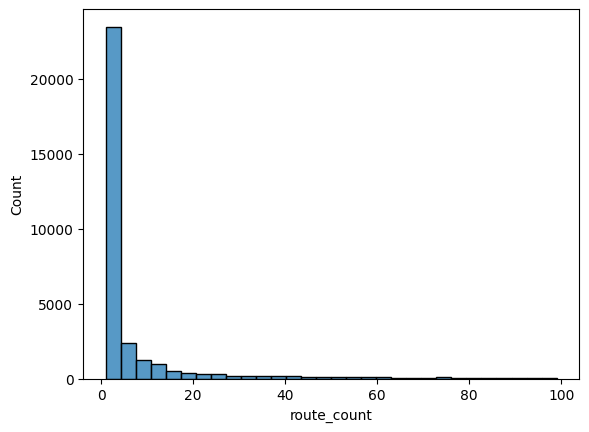

In [321]:
import seaborn as sns
sns.histplot(data=routes_df[routes_df['route_count'] < 100], x='route_count', bins=30)

In [322]:
routes_df['route_time'] = routes_df['dt_insert_utc_last'] - routes_df['dt_insert_utc_first']

In [255]:
!pip install geopy
import geopy.distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 4.7 MB/s eta 0:00:00


In [324]:
routes_df['distance'] = [geopy.distance.geodesic([latitude_first, longitude_first], [latitude_last, longitude_last]).km
                         for (latitude_first, longitude_first, latitude_last, longitude_last) in
                         zip(routes_df['latitude_first'], routes_df['longitude_first'], routes_df['latitude_last'], routes_df['longitude_last'])]

In [325]:
routes_df

dt_insert_utc_first  dt_insert_utc_last  \
mmsi      route destination                                                   
203999383 1     CONSTANTA           2019-03-25 02:25:41 2019-03-25 05:26:00   
          2     KLIZSKA NEMA        2019-03-25 05:33:54 2019-03-25 05:33:54   
          3     CONSTANTA           2019-03-25 05:36:34 2019-03-25 06:14:02   
          4     KLIZSKA NEMA        2019-03-25 06:18:51 2019-03-25 06:18:51   
          5     CONSTANTA           2019-03-25 06:24:02 2019-03-25 06:44:08   
...                                                 ...                 ...   
677092400 5     BANGHAZI / LIBYA    2019-03-28 19:54:50 2019-03-29 20:40:12   
          7     BANGHAZI / LIBYA    2019-03-29 20:40:19 2019-04-14 23:09:07   
677096200 1     MISURATA            2019-03-25 01:09:30 2019-03-25 04:27:00   
          2     NLKAM10084HRARE0001 2019-03-25 04:39:00 2019-03-25 04:39:00   
          3     MISURATA            2019-03-25 04:49:40 2019-04-13 19:01:35   

                                     latitude_first  latitude_last  \
mmsi      route destination                                          
203999383 1     CONSTANTA                 45.826287      45.588313   
          2     KLIZSKA NEMA              45.577460      45.577460   
          3     CONSTANTA                 45.573232      45.533590   
          4     KLIZSKA NEMA              45.533115      45.533115   
          5     CONSTANTA                 45.534847      45.554627   
...                                             ...            ...   
677092400 5     BANGHAZI / LIBYA          32.106792      32.106787   
          7     BANGHAZI / LIBYA          32.106833      32.712833   
677096200 1     MISURATA                  40.651372      40.134597   
          2     NLKAM10084HRARE0001       40.098427      40.098427   
          3     MISURATA                  40.067680      31.584105   

                                     longitude_first  longitude_last  \
mmsi      route destination                                            
203999383 1     CONSTANTA                  18.852413       18.902228   
          2     KLIZSKA NEMA               18.889852       18.889852   
          3     CONSTANTA                  18.887872       18.948965   
          4     KLIZSKA NEMA               18.960153       18.960153   
          5     CONSTANTA                  18.972773       19.010715   
...                                              ...             ...   
677092400 5     BANGHAZI / LIBYA           20.044840       20.044843   
          7     BANGHAZI / LIBYA           20.044833       20.284000   
677096200 1     MISURATA                   18.302312       18.725785   
          2     NLKAM10084HRARE0001        18.731063       18.731063   
          3     MISURATA                   18.722293       31.744750   

                                     route_count       route_time     distance  
mmsi      route destination                                                     
203999383 1     CONSTANTA                     35  0 days 03:00:19    26.732632  
          2     KLIZSKA NEMA                   1  0 days 00:00:00     0.000000  
          3     CONSTANTA                      8  0 days 00:37:28     6.493740  
          4     KLIZSKA NEMA                   1  0 days 00:00:00     0.000000  
          5     CONSTANTA                      5  0 days 00:20:06     3.689566  
...                                          ...              ...          ...  
677092400 5     BANGHAZI / LIBYA             195  1 days 00:45:22     0.000637  
          7     BANGHAZI / LIBYA            1308 16 days 02:28:48    70.867836  
677096200 1     MISURATA                      18  0 days 03:17:30    67.716720  
          2     NLKAM10084HRARE0001            1  0 days 00:00:00     0.000000  
          3     MISURATA                     129 19 days 14:11:55  1504.060540  

[36872 rows x 9 columns]

<AxesSubplot: xlabel='distance', ylabel='Count'>

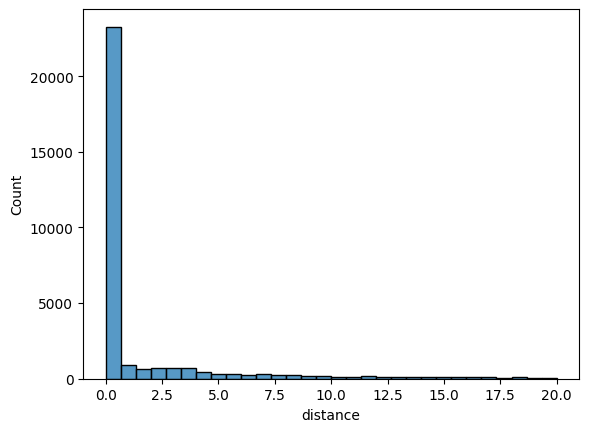

In [326]:
sns.histplot(data=routes_df[routes_df['distance'] < 20], x='distance', bins=30)

In [327]:
routes_df['real_route'] = routes_df['distance'] > 0.5

In [328]:
routes_df.groupby('real_route')['route_count'].count()

real_route
False    22988
True     13884
Name: route_count, dtype: int64

In [329]:
routes_df.groupby('real_route')['route_count'].sum()

real_route
False     791987
True     3000155
Name: route_count, dtype: int64

In [330]:
real_routes = routes_df[routes_df['distance'] > 50].reset_index()

In [331]:
real_routes['consecutive'] = real_routes['route'] - real_routes['route'].shift(1)
real_routes[real_routes['consecutive'] == 0]

,mmsi,route,destination,dt_insert_utc_first,dt_insert_utc_last,latitude_first,latitude_last,longitude_first,longitude_last,route_count,route_time,distance,real_route,consecutive
43,207262337,16,RUSE,2019-03-30 00:00:50,2019-04-14 19:08:11,44.101222,43.903510,28.588238,26.058110,168,15 days 19:07:21,204.101262,True,0.0
166,215231000,2,PTAVE,2019-03-28 00:09:39,2019-03-28 23:54:06,38.519017,40.365700,-8.881500,-9.068400,143,0 days 23:44:27,205.656243,True,0.0
529,248975000,1,GIGIB,2019-03-25 00:09:54,2019-03-25 23:33:23,36.201967,35.892900,-5.063050,-5.493533,85,0 days 23:23:29,51.776304,True,0.0
602,249632000,1,AU PHE,2019-03-25 00:08:32,2019-03-28 09:52:37,2.075317,-14.659053,119.373397,117.137157,655,3 days 09:44:05,1867.091005,True,0.0
681,256183000,2,RU YEY,2019-04-01 05:53:58,2019-04-11 20:52:49,41.722683,46.732260,32.173117,38.267153,1025,10 days 14:58:51,739.084502,True,0.0
901,264162493,1,BRAILA>GROPENI,2019-03-25 04:22:43,2019-03-25 17:23:22,45.197127,45.433413,28.789993,28.188215,69,0 days 13:00:39,54.002182,True,0.0
905,264162519,6,PRAHOVO,2019-03-28 00:02:01,2019-04-01 09:31:48,44.096033,44.719260,28.671505,21.027353,736,4 days 09:29:47,612.589048,True,0.0
940,264162967,1,LOM,2019-03-25 00:03:10,2019-04-04 07:59:57,43.843333,44.027842,23.273333,26.318730,920,10 days 07:56:47,245.367458,True,0.0
943,264163065,1,PERIPRAVA,2019-04-01 08:04:32,2019-04-08 10:20:20,45.442867,45.181047,28.087350,28.794857,15,7 days 02:15:48,62.648334,True,0.0
944,264163123,1,GYOR GYONU,2019-03-25 00:07:13,2019-03-25 11:31:12,48.638698,48.386322,13.180222,14.019537,80,0 days 11:23:59,68.065708,True,0.0


In [332]:
routes_df = routes_df.reset_index()

In [333]:
routes_df[routes_df['mmsi'] == 264162493].sort_values(by=['route'])

,mmsi,route,destination,dt_insert_utc_first,dt_insert_utc_last,latitude_first,latitude_last,longitude_first,longitude_last,route_count,route_time,distance,real_route
7925,264162493,1,BRAILA>GROPENI,2019-03-25 04:22:43,2019-03-25 17:23:22,45.197127,45.433413,28.789993,28.188215,69,0 days 13:00:39,54.002182,True
7926,264162493,2,TULCEA,2019-03-26 03:42:32,2019-03-26 06:01:23,45.433400,45.415115,28.188257,28.039555,20,0 days 02:18:51,11.813904,True
7927,264162493,3,BRAILA>GROPENI,2019-03-26 06:09:22,2019-03-26 06:09:22,45.406820,45.406820,28.030210,28.030210,1,0 days 00:00:00,0.000000,False
7928,264162493,4,TULCEA,2019-03-26 06:13:42,2019-03-26 09:11:34,45.401603,45.189667,28.027473,27.945155,25,0 days 02:57:52,24.423152,True
7929,264162493,5,BRAILA>GROPENI,2019-03-26 09:27:52,2019-03-26 09:27:52,45.167558,45.167558,27.942632,27.942632,1,0 days 00:00:00,0.000000,False
7930,264162493,6,TULCEA,2019-03-26 09:39:32,2019-03-26 14:12:02,45.154305,45.285827,27.952852,27.993660,6,0 days 04:32:30,14.964111,True
7931,264162493,7,BRAILA>GROPENI,2019-03-26 14:22:43,2019-03-26 14:22:43,45.312570,45.312570,28.000775,28.000775,1,0 days 00:00:00,0.000000,False
7932,264162493,8,TULCEA,2019-03-26 14:33:34,2019-03-26 16:28:24,45.339105,45.445220,28.012262,28.275230,13,0 days 01:54:50,23.730356,True
7933,264162493,9,BRAILA>GROPENI,2019-03-26 16:39:12,2019-03-26 16:39:12,45.419973,45.419973,28.285458,28.285458,1,0 days 00:00:00,0.000000,False
7934,264162493,10,TULCEA,2019-03-26 16:49:44,2019-03-26 19:19:24,45.392858,45.217047,28.290262,28.752625,17,0 days 02:29:40,41.191120,True


In [335]:
routes_df = routes_df[routes_df['distance'] != 0]
routes_df

,mmsi,route,destination,dt_insert_utc_first,dt_insert_utc_last,latitude_first,latitude_last,longitude_first,longitude_last,route_count,route_time,distance,real_route
0,203999383,1,CONSTANTA,2019-03-25 02:25:41,2019-03-25 05:26:00,45.826287,45.588313,18.852413,18.902228,35,0 days 03:00:19,26.732632,True
2,203999383,3,CONSTANTA,2019-03-25 05:36:34,2019-03-25 06:14:02,45.573232,45.533590,18.887872,18.948965,8,0 days 00:37:28,6.493740,True
4,203999383,5,CONSTANTA,2019-03-25 06:24:02,2019-03-25 06:44:08,45.534847,45.554627,18.972773,19.010715,5,0 days 00:20:06,3.689566,True
6,203999383,7,CONSTANTA,2019-03-25 06:54:10,2019-03-25 08:42:01,45.549750,45.480772,19.026677,18.990930,22,0 days 01:47:51,8.159349,True
8,203999383,9,CONSTANTA,2019-03-25 08:52:01,2019-03-25 11:33:09,45.463798,45.303707,18.990038,19.099995,32,0 days 02:41:08,19.766959,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36865,677092400,3,BANGHAZI / LIBYA,2019-03-27 18:56:51,2019-03-28 19:54:10,32.106800,32.106833,20.044827,20.044833,329,1 days 00:57:19,0.003749,False
36867,677092400,5,BANGHAZI / LIBYA,2019-03-28 19:54:50,2019-03-29 20:40:12,32.106792,32.106787,20.044840,20.044843,195,1 days 00:45:22,0.000637,False
36868,677092400,7,BANGHAZI / LIBYA,2019-03-29 20:40:19,2019-04-14 23:09:07,32.106833,32.712833,20.044833,20.284000,1308,16 days 02:28:48,70.867836,True
36869,677096200,1,MISURATA,2019-03-25 01:09:30,2019-03-25 04:27:00,40.651372,40.134597,18.302312,18.725785,18,0 days 03:17:30,67.716720,True


In [339]:
routes_df['new_route'] =  routes_df.groupby('mmsi').apply(
    lambda x: (x['destination'] != x['destination_lag']).cumsum()
).reset_index(level=0, drop=True)

/tmp/ipykernel_817/1797577419.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes_df['new_route'] =  routes_df.groupby('mmsi').apply(


In [343]:
new_routes_df = routes_df.groupby(['mmsi', 'new_route', 'destination']).agg(
    {
        'dt_insert_utc_first': 'first',
        'dt_insert_utc_last': 'last',
        'latitude_first': 'first',
        'latitude_last': 'last',
        'longitude_first': 'first',
        'longitude_last': 'last',
    }
).reset_index()
new_routes_df

,mmsi,new_route,destination,dt_insert_utc_first,dt_insert_utc_last,latitude_first,latitude_last,longitude_first,longitude_last
0,203999383,1,CONSTANTA,2019-03-25 02:25:41,2019-04-13 18:48:13,45.826287,43.848735,18.852413,25.937700
1,203999385,1,BRATISLAVA,2019-03-25 00:03:08,2019-04-14 23:59:06,48.126865,48.126650,17.153325,17.156872
2,203999389,1,BAIJA,2019-03-25 00:01:19,2019-04-14 23:55:53,44.117348,44.117333,28.643607,28.643602
3,207008000,1,POTI,2019-03-25 00:24:33,2019-03-30 08:50:20,43.188133,43.417903,27.677577,39.431965
4,207008000,2,CHORNOMORSK,2019-03-30 09:01:38,2019-04-01 07:38:33,43.439973,46.344067,39.396180,30.651953
...,...,...,...,...,...,...,...,...,...
12013,677085700,1,RASA,2019-03-25 01:43:13,2019-03-27 09:57:12,37.709032,44.920538,20.643092,14.083112
12014,677085700,2,ALEXANDRIA,2019-03-29 18:14:36,2019-04-07 04:29:12,44.881700,34.339057,14.086032,28.197270
12015,677085700,3,UA NIK,2019-04-07 04:34:51,2019-04-14 23:48:28,34.353887,46.323010,28.190180,31.071918
12016,677092400,1,BANGHAZI / LIBYA,2019-03-25 01:44:46,2019-04-14 23:09:07,32.126507,32.712833,19.984530,20.284000


In [348]:
new_routes_df.mmsi.nunique()

1415

In [346]:
new_routes_df.groupby('mmsi')['mmsi'].count().value_counts()

1      357
3      179
4      112
5      108
2      105
      ... 
62       1
44       1
100      1
53       1
87       1
Name: mmsi, Length: 69, dtype: int64